In [243]:
from git import Repo
import shutil
import os
import glob
from shutil import copyfile
import os
import urllib.request
import fnmatch
import os
import requests
import json
import matplotlib.pyplot as plt  # To visualize
import numpy
import pygount
from sklearn.linear_model import LinearRegression

import pandas as pd
dtypes = numpy.dtype([
          ('Repo', str),
          ('Eslint Errors per 100 lines', float),
          ('Stars', int),
          ('Lines of code', int)
          ])
data = numpy.empty(0, dtype=dtypes)
df = pd.DataFrame(data)

# Future work
#  1. Find out a way to use existing eslint config in the repos. The main problem we run into is the extends
#     but maybe there is a way to download the extends in the script
#  2. Find out number of contributors. some funny things going on with pagination when you try /stats/contributors

In [180]:
def lines_of_code_counter():
    #!/usr/bin/env python

    # This Python script counts the lines of code in the directory in which it is
    # run.  It only looks at files which end in the file extensions passed to the
    # script as arguments.

    # It outputs counts for total lines, blank lines, comment lines and code lines
    # (total lines minus blank lines and comment lines).

    # Example usage and output:
    # > lines_of_code_counter.py .h .cpp
    # Total lines:   15378
    # Blank lines:   2945
    # Comment lines: 1770
    # Code lines:    10663

    # Change this value based on the comment symbol used in your programming
    # language.
    commentSymbol = "//"

    import sys
    import os, os.path

    acceptableFileExtensions = [".js"]
    if not acceptableFileExtensions:
        print('Please pass at least one file extension as an argument.')
        quit()

    currentDir = os.getcwd()

    filesToCheck = []
    for root, _, files in os.walk(currentDir):
        for f in files:
            fullpath = os.path.join(root, f)
            if '.git' not in fullpath:
                for extension in acceptableFileExtensions:
                    if fullpath.endswith(extension):
                        filesToCheck.append(fullpath)

    if not filesToCheck:
        print('No files found.')
        quit()

    lineCount = 0
    totalBlankLineCount = 0
    totalCommentLineCount = 0

#     print('')
#     print('Filename\tlines\tblank lines\tcomment lines\tcode lines')

    for fileToCheck in filesToCheck:
        with open(fileToCheck) as f:

            fileLineCount = 0
            fileBlankLineCount = 0
            fileCommentLineCount = 0

            for line in f:
                lineCount += 1
                fileLineCount += 1

                lineWithoutWhitespace = line.strip()
                if not lineWithoutWhitespace:
                    totalBlankLineCount += 1
                    fileBlankLineCount += 1
                elif lineWithoutWhitespace.startswith(commentSymbol):
                    totalCommentLineCount += 1
                    fileCommentLineCount += 1

#             print(os.path.basename(fileToCheck) + \
#                   "\t" + str(fileLineCount) + \
#                   "\t" + str(fileBlankLineCount) + \
#                   "\t" + str(fileCommentLineCount) + \
#                   "\t" + str(fileLineCount - fileBlankLineCount - fileCommentLineCount))


#     print('')
#     print('Totals')
#     print('--------------------')
#     print('Lines:         ' + str(lineCount))
#     print('Blank lines:   ' + str(totalBlankLineCount))
#     print 'Comment lines: ' + str(totalCommentLineCount)
#     print('Code lines:    ' + str(lineCount - totalBlankLineCount - totalCommentLineCount))
    return (lineCount - totalBlankLineCount - totalCommentLineCount)

In [244]:
js_repos = ["/reduxjs/redux", 
            "/zalmoxisus/redux-devtools-extension",
           "/faceyspacey/redux-first-router",
            "/faceyspacey/redux-first-router-link",
            "/reduxjs/redux-thunk",
            "/googlechrome/workbox",
            "/cypress-io/cypress",
            "/airbnb/enzyme",
            "/eslint/eslint",
            "/wheresrhys/fetch-mock",
            "/facebook/jest",
            "/bitinn/node-fetch",
            "/prettier/prettier",
            "/pinterest/service-workers",
            "/bahmutov/start-server-and-test",
            "/webpack/webpack-dev-server"
           ]
# js_repos = ["/reduxjs/redux"]

for js_repo in js_repos:
    cloned_repo_dir = "/Users/gmholden/workspace/python_projects/cloned_repo"
    
    print("cleaning out any files in repo directory")
    if os.path.exists(cloned_repo_dir):
        for root, dirs, files in os.walk(cloned_repo_dir):
            for f in files:
                os.unlink(os.path.join(root, f))
            for d in dirs:
                shutil.rmtree(os.path.join(root, d)) 
    
    print("Cloning down " + js_repo)
    Repo.clone_from("https://github.com" + js_repo, cloned_repo_dir)
    os.chdir(cloned_repo_dir)
    
    print("counting lines of code..")
    lines_of_code = lines_of_code_counter()
    print(lines_of_code)

    print("destroying any existing eslint config")
    filePattern = cloned_repo_dir + '/*eslintrc*'
    matches = []
    for root, dirnames, filenames in os.walk(cloned_repo_dir):
        for filename in fnmatch.filter(filenames, '*eslintrc*'):
            matches.append(os.path.join(root, filename))
    for filePath in matches:
        try:
            os.remove(filePath)
        except OSError:
            print("Error while deleting file")
    print("finished deleting all existing eslint config")
    
    print("running eslint..")
    os.chdir('..')

    current_path = os.path.abspath('')
    filename = os.path.join(current_path, '.eslintrc.js')
    copyfile(filename, cloned_repo_dir + "/.eslintrc.js")
    results = os.popen('/Users/gmholden/.nvm/versions/node/v10.15.3/bin/eslint cloned_repo').read()
    lines = results.splitlines()
    error_line = lines[-3:-1]
    s = ' '
    errors = s.join(error_line).split('(')[1].split(',')[0].split(' ')[0]
    
    contents = urllib.request.urlopen("http://api.github.com/repos" + js_repo).read()
    json_contents = json.loads(contents)
    stars = json_contents['watchers']
    
     #https://api.github.com/repos/:owner/:repo/contributors?per_page=1
#      r = requests.get("http://api.github.com/repos" + js_repo + "/stats/contributors?per_page=1")
#      print(r.headers)
#      contributors_array = json.loads(r.content)
#      print(len(contributors_array))
    
    df = df.append({'Repo' : js_repo , 'Eslint Errors per 100 lines' : float(errors)/(float(lines_of_code)/100), 'Stars': int(stars), 'Lines of code': lines_of_code } , ignore_index=True)


cleaning out any files in repo directory
Cloning down /reduxjs/redux
counting lines of code..
7742
destroying any existing eslint config
finished deleting all existing eslint config
running eslint..
cleaning out any files in repo directory
Cloning down /zalmoxisus/redux-devtools-extension
counting lines of code..
11412
destroying any existing eslint config
finished deleting all existing eslint config
running eslint..
cleaning out any files in repo directory
Cloning down /faceyspacey/redux-first-router
counting lines of code..
6787
destroying any existing eslint config
finished deleting all existing eslint config
running eslint..
cleaning out any files in repo directory
Cloning down /faceyspacey/redux-first-router-link
counting lines of code..
11637
destroying any existing eslint config
finished deleting all existing eslint config
running eslint..
cleaning out any files in repo directory
Cloning down /reduxjs/redux-thunk
counting lines of code..
128
destroying any existing eslint config

IndexError: list index out of range

In [241]:
X = pd.DataFrame(df['Eslint Errors per 100 lines'])
y = pd.DataFrame(df['Stars'])
# print(y)
# model = LinearRegression()
# model.fit(X,Y)


model = LinearRegression()
model.fit(X, y)

Y_pred = model.predict(X)  # make predictions
Y_pred

array([[14083.75447382],
       [ 9664.30164104],
       [13248.06908459],
       [ 8674.14465612],
       [20001.57548134],
       [12990.69891185],
       [18679.45575124]])

                                   Repo  Eslint Errors per 100 lines  Stars  \
0                        /reduxjs/redux                     7.775769  50381   
1  /zalmoxisus/redux-devtools-extension                     2.497371   9842   
2       /faceyspacey/redux-first-router                     6.777663   1480   
3  /faceyspacey/redux-first-router-link                     1.314772     54   
4                  /reduxjs/redux-thunk                    14.843750  13045   
5                 /googlechrome/workbox                     6.470272   8166   
6                   /cypress-io/cypress                    13.264669  14374   

   Lines of code  
0           7742  
1          11412  
2           6787  
3          11637  
4            128  
5          14868  
6          54468  


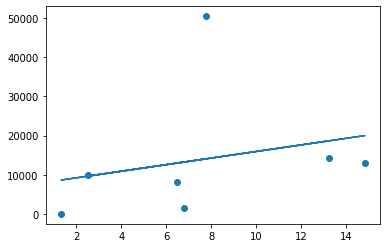

In [242]:
print(df)
plt.scatter(X , y)
plt.plot(X, Y_pred)
# plot(X, Y_pred, color='red')
